# 07. bonniema/salary-predictor

## Model 2: Count Vectorizer + TF-IDF with Grid Search

## Import libraries and the final salary dataset

In [44]:
import time
from time import time
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging

# NLP
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.collocations import *
import string, re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Deep learning
import tensorflow as tf
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier #to use Keras in sklearn

# Deep Learning - Mixed inputs
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam, RMSprop

%matplotlib inline
np.random.seed(0)

[nltk_data] Downloading package stopwords to C:\Users\Doğan Yiğit
[nltk_data]     Yenigün\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
salary_df = pd.read_csv('salary_final_done.csv')

In [46]:
print(salary_df.shape)
salary_df.drop('Unnamed: 0.2', axis=1, inplace=True)
salary_df.drop('Unnamed: 0.1', axis=1, inplace=True)
salary_df.drop('Unnamed: 0', axis=1, inplace=True)
salary_df.head()

(963, 27)


,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,low,high,...,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,combined_text,Salary_Bins
0,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,"Up to $215,000 a year",NaN,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,"2021048 Data Scientist $215,000.00 Position Re...",5
1,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,"$60,000 a year",NaN,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science/Data Analyst Cost Readiness Analy...,1
2,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,$20,$25 an hour,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science Intern Job Title: Data Science In...,0
3,Jr. Data Scientist,Numero Data LLC,https://www.indeed.com/company/Numero-Data-LLC...,None,"$70,000 - $85,000 a year",Ideal candidate should have a degree in a quan...,"Arlington, VA",Yearly,"$70,000","$85,000 a year",...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Jr. Data Scientist Ideal candidate should have...,2
4,Business Data Quality Engineer,HRU Technical Resources,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,$45 - $55 an hour,Please note that this is not a corp to corp or...,"Arlington, VA",Hourly,$45,$55 an hour,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Business Data Quality Engineer Please note tha...,3


In [47]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Title                           963 non-null    object 
 1   Company                         963 non-null    object 
 2   Link                            963 non-null    object 
 3   Review                          963 non-null    object 
 4   Salary                          963 non-null    object 
 5   Description                     963 non-null    object 
 6   Location2                       958 non-null    object 
 7   Rate_by                         963 non-null    object 
 8   low                             963 non-null    object 
 9   high                            762 non-null    object 
 10  min                             963 non-null    float64
 11  max                             963 non-null    float64
 12  adjusted_salary                 963 

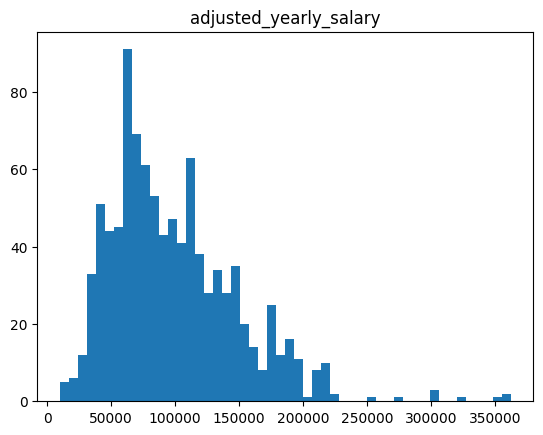

In [48]:
salary_df.hist('adjusted_yearly_salary', bins=50)
plt.grid(axis='both')
plt.show()

In [49]:
salary_df['adjusted_yearly_salary'].max() - salary_df['adjusted_yearly_salary'].min()

352500.0

In [50]:
salary_df['adjusted_yearly_salary'].quantile(list(np.linspace(0,1,7)))

0.000000     10000.000000
0.166667     54026.666667
0.333333     70000.000000
0.500000     90000.000000
0.666667    114400.000000
0.833333    145600.000000
1.000000    362500.000000
Name: adjusted_yearly_salary, dtype: float64

In [51]:
salary_df['Salary_Bins']

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: int64

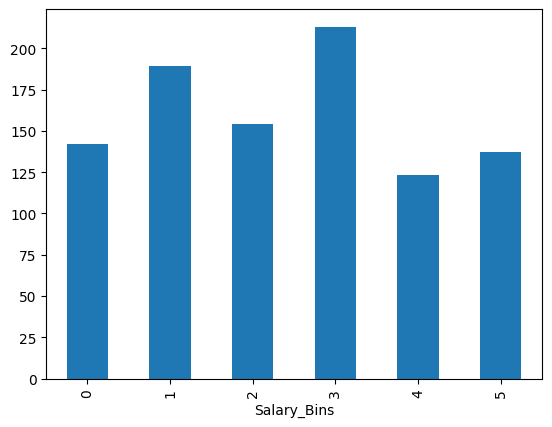

In [52]:
salary_df.groupby('Salary_Bins')['Location2'].count().plot.bar()
plt.show()

In [53]:
# Categorical target
target_class = salary_df['Salary_Bins'].astype('category')

In [54]:
def clean_word(job_descriptions):
    jd_data=[]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    stopwords_list += ['www','http','com','llc','covid','non','pm','am','eg','e','g','ie','i']
    
    for jd in job_descriptions:
        jd_tokens_raw = nltk.regexp_tokenize(jd, pattern)
        jd_tokens=[word.lower() for word in jd_tokens_raw]
        jd_words_stopped = [word for word in jd_tokens if word not in stopwords_list]
        jd_data.append(jd_words_stopped)

    return pd.Series(jd_data) # Turn list of lists to series of lists to use in Word2Vec

In [55]:
data = clean_word(salary_df['combined_text'])

In [56]:
data

0      [data, scientist, position, requires, top, sec...
1      [data, science, data, analyst, cost, readiness...
2      [data, science, intern, job, title, data, scie...
3      [jr, data, scientist, ideal, candidate, degree...
4      [business, data, quality, engineer, please, no...
                             ...                        
958    [data, engineering, ii, data, engineering, ii,...
959    [ir, day, shift, tier, ir, day, shift, salary,...
960    [security, engineer, security, engineer, salar...
961    [fdp, analyst, position, title, fdp, analyst, ...
962    [junior, ms, access, vba, developer, want, acc...
Length: 963, dtype: object

## Model 2: Count Vectorizer + TF-IDF with Grid Search

TF means **Term-Frequency**, while TF-IDF means **Term-Frequency times Inverse-Document-Frequency**. This is a common term weighting scheme for information retrieval. 

The goal of using TF-IDF instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus. Therefore, they are empirically less informative than features that occur in a small fraction of the training corpus.

In [57]:
# The input needs to be raw text
text = salary_df['combined_text']

In [58]:
text

0      2021048 Data Scientist $215,000.00 Position Re...
1      Data Science/Data Analyst Cost Readiness Analy...
2      Data Science Intern Job Title: Data Science In...
3      Jr. Data Scientist Ideal candidate should have...
4      Business Data Quality Engineer Please note tha...
                             ...                        
958    Data Engineering II Data Engineering II\rSalar...
959    IR Day Shift Tier 2 IR Day Shift\rSalary Range...
960    Security Engineer Security Engineer\rSalary Ra...
961    FDP Analyst Position Title: FDP Analyst\rCusto...
962    Junior MS Access/ VBA Developer If you want an...
Name: combined_text, Length: 963, dtype: object

In [79]:
text[0]

'2021048 Data Scientist $215,000.00 Position Requires a Top Secret (TS/SCI) Clearance with a Polygraph.\rEstimated Salary:\rPosition Level: Level 1 \x8a\x97\x96 Subject Matter Expert\rSalary Range: Up to $215,000.00 per year\rB4Corp Estimated Salary Ranges:\rPosition Level Min Salary Max Salary\rLevel 1 \x8a\x97\x96 Subject Matter Expert $160,000 $215,000\rLevel 2 \x8a\x97\x96 Expert $140,000 $195,000\rLevel 3 \x8a\x97\x96 Senior $110,000 $170,000\rLevel 4 \x8a\x97\x96 Full Performance $60,000 $100,000\rMandatory Requirements:\r1. Java development experience in a production environment. (Required for Software Developer) (list years\x8a\x97È experience only)\r2. Demonstrated on-the-job experience troubleshooting user issues (list years\x8a\x97È experience only)\r3. Demonstrated on-the-job experience writing system automation scripts for a Linux environment using tools such as: bash/sh, python, ruby, or perl (list years\x8a\x97È experience only)\r4. Demonstrated on-the-job experience ins

In [59]:
target_class

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [60]:
# TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(text, target_class, test_size=0.1, random_state=4)

### SGD Classifier with Grid Search

In [61]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, min_df=5, ngram_range=(1,2), stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(n_jobs=3))
])

# Uncommenting more parameters will give better exploring power but will increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.2,0.5),
    'vect__min_df': (0.01,0.05),
    #'tfidf__use_idf': (True, False),
    #'tfidf__smooth_idf': (True, False),
    'clf__alpha': (0.0001,0.001),
    'clf__loss': ('hinge','log'), 
    #'clf__penalty': ('l2','elasticnet'),
    'clf__max_iter': (100,200,500)
}

if __name__ == "__main__":
    # Multiprocessing requires the fork to happen in a __main__ protected block
    # Find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.0001, 0.001),
 'clf__loss': ('hinge', 'log'),
 'clf__max_iter': (100, 200, 500),
 'vect__max_df': (0.2, 0.5),
 'vect__min_df': (0.01, 0.05)}
Fitting 5 folds for each of 48 candidates, totalling 240 fits
done in 100.743s

Best score: 0.549
Best parameters set:
	clf__alpha: 0.001
	clf__loss: 'hinge'
	clf__max_iter: 200
	vect__max_df: 0.2
	vect__min_df: 0.01


In [62]:
SGD = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, min_df=0.01, ngram_range=(1,3), stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(alpha=0.001, max_iter=200, n_jobs=3))
])

In [63]:
classifier = SGD.fit(X_train, y_train)

In [64]:
y_pred = SGD.predict(X_test)

### Confusion Matrix

In [65]:
confusion_matrix(y_test, y_pred)

array([[11,  1,  0,  0,  0,  0],
       [ 1, 13,  2,  1,  0,  0],
       [ 1,  4,  7,  1,  0,  0],
       [ 0,  2,  3, 17,  0,  0],
       [ 0,  0,  0,  2,  9,  1],
       [ 1,  2,  0,  1,  4, 13]], dtype=int64)

C:\Users\Doğan Yiğit Yenigün\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[11  1  0  0  0  0]
 [ 1 13  2  1  0  0]
 [ 1  4  7  1  0  0]
 [ 0  2  3 17  0  0]
 [ 0  0  0  2  9  1]
 [ 1  2  0  1  4 13]]


C:\Users\Doğan Yiğit Yenigün\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[0.92 0.08 0.   0.   0.   0.  ]
 [0.06 0.76 0.12 0.06 0.   0.  ]
 [0.08 0.31 0.54 0.08 0.   0.  ]
 [0.   0.09 0.14 0.77 0.   0.  ]
 [0.   0.   0.   0.17 0.75 0.08]
 [0.05 0.1  0.   0.05 0.19 0.62]]


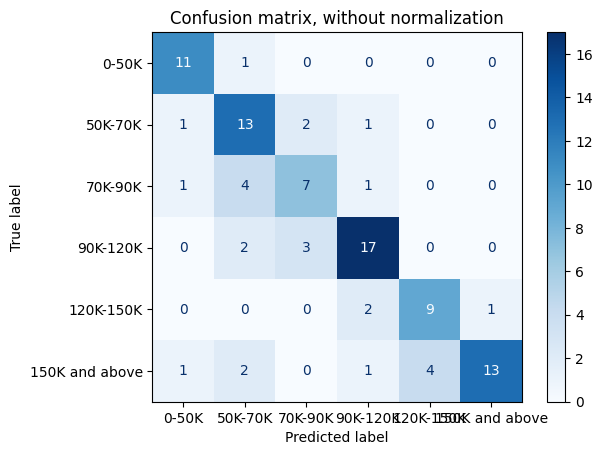

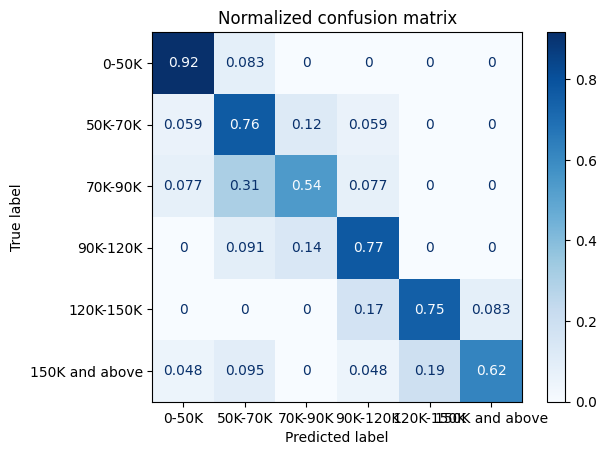

In [66]:
# Visualize Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
np.set_printoptions(precision=2)

class_names = ["0-50K","50K-70K","70K-90K","90K-120K",'120K-150K','150K and above']
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)  
    print(title)
    print(disp.confusion_matrix)
plt.show()

In [67]:
# Mean accuracy on the given test data and labels
SGD.score(X_test, y_test)

0.7216494845360825

In [68]:
# Save the model to disk
filename = 'finalized_sgd_model.sav'
pickle.dump(SGD, open(filename, 'wb'))

In [70]:
# Load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.7216494845360825


Using CountVectorizer and TF-IDF Transformer with SGD did much better than previous model, Word2Vec and RandomForest! We can imply that TF-IDF was able to retrieve valuable information.

### Random Forest Classifier with Grid Search

In [71]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, min_df=0.01, ngram_range=(1,2), stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_jobs=3))
])

# Uncommenting more parameters will give better exploring power but will increase processing time in a combinatorial way
parameters = {
    'tfidf__use_idf':(True, False),
    'tfidf__smooth_idf':(True, False),
    'rf__n_estimators':(30,40,50),
    'rf__criterion':("gini","entropy"),
    'rf__min_samples_split':(2,6,8),
    'rf__max_features':("auto","sqrt","log2")   
}

if __name__ == "__main__":
    # Multiprocessing requires the fork to happen in a __main__ protected block
    # Find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'rf']
parameters:
{'rf__criterion': ('gini', 'entropy'),
 'rf__max_features': ('auto', 'sqrt', 'log2'),
 'rf__min_samples_split': (2, 6, 8),
 'rf__n_estimators': (30, 40, 50),
 'tfidf__smooth_idf': (True, False),
 'tfidf__use_idf': (True, False)}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
done in 695.684s

Best score: 0.550
Best parameters set:
	rf__criterion: 'gini'
	rf__max_features: 'sqrt'
	rf__min_samples_split: 8
	rf__n_estimators: 50
	tfidf__smooth_idf: False
	tfidf__use_idf: False


Yep, performance is similar to SGD.

In [72]:
rf = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, min_df=0.03, ngram_range=(1,3), stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(max_features='sqrt', min_samples_split=8, n_estimators=50, n_jobs=3))
])

In [73]:
rf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, min_df=0.03, ngram_range=(1, 3),
                                 stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('rf',
                 RandomForestClassifier(min_samples_split=8, n_estimators=50,
                                        n_jobs=3))])

In [77]:
y_pred = rf.predict(X_test)

In [78]:
rf.score(X_test, y_test)

0.5979381443298969

Well, SGD outperforms RandomForest in this case.